# 데이터 가져오기

## 데이터 다운로드

In [156]:
# 데이터 추출 및 로드
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path('datasets/housing.tgz')
    if not tarball_path.is_file():
        Path('datasets').mkdir(parents=True, exist_ok=True)
    url = 'https://github.com/ageron/data/raw/main/housing.tgz'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path='datasets')
    return pd.read_csv(Path('datasets/housing/housing.csv'))

housing = load_housing_data()

## 데이터 구조 훑어보기

In [157]:
# 데이터 확인
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [158]:
# 데이터 설명 확인
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [159]:
# 데이터 카테고리별 갯수 확인
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [160]:
# 숫자형 특성 기술 통계량 확인
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


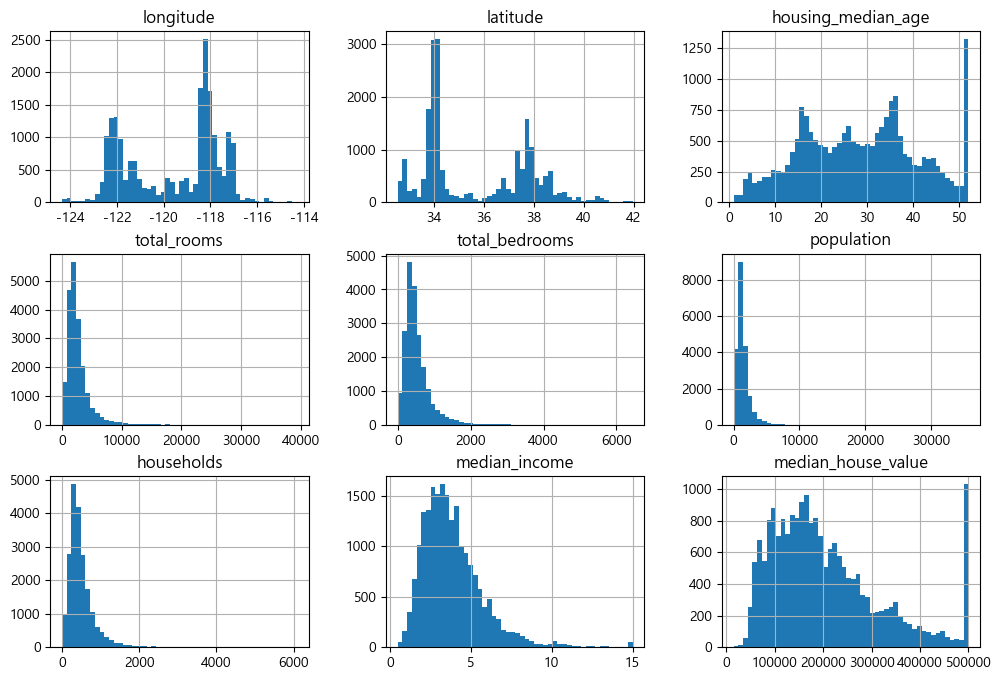

In [161]:
# 히스토그램 그리기
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(12, 8))
plt.show()

## 테스트 세트 만들기

In [162]:
# 테스트 세트 만들기 
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indicies = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indicies]

In [163]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

In [164]:
# 해시를 이용한 테스트 세트 만들기
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2 ** 32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_ : is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [165]:
housing_with_id = housing.reset_index()

train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

len(train_set), len(test_set)

(16512, 4128)

In [166]:
# index 대신 고유한 특성을 사용
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, 'id')

len(train_set), len(test_set)

(16322, 4318)

In [167]:
# 사이킷런 사용
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [168]:
# 계층적 샘플링
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

In [169]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

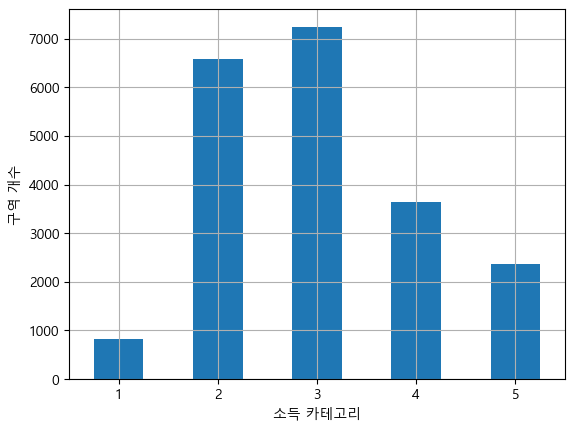

In [170]:
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('소득 카테고리')
plt.ylabel('구역 개수')
plt.show()

In [171]:
# 여러 분할로 계층적 분할
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing['income_cat']):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [172]:
strat_train_set, start_test_set = strat_splits[0]

In [173]:
# 하나의 계층적 분할
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing['income_cat'], random_state=42)

In [174]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [175]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

# 데이터 이해를 위한 탐색과 시각화

In [176]:
housing = strat_train_set.copy()

지리적 데이터 시각화하기

Text(0, 0.5, '위도')

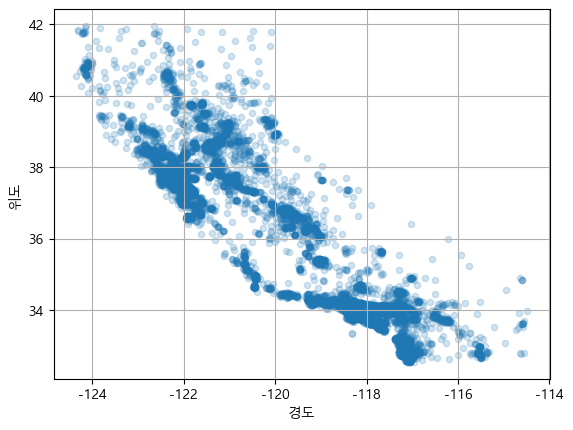

In [177]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.2)
plt.xlabel('경도')
plt.ylabel('위도')

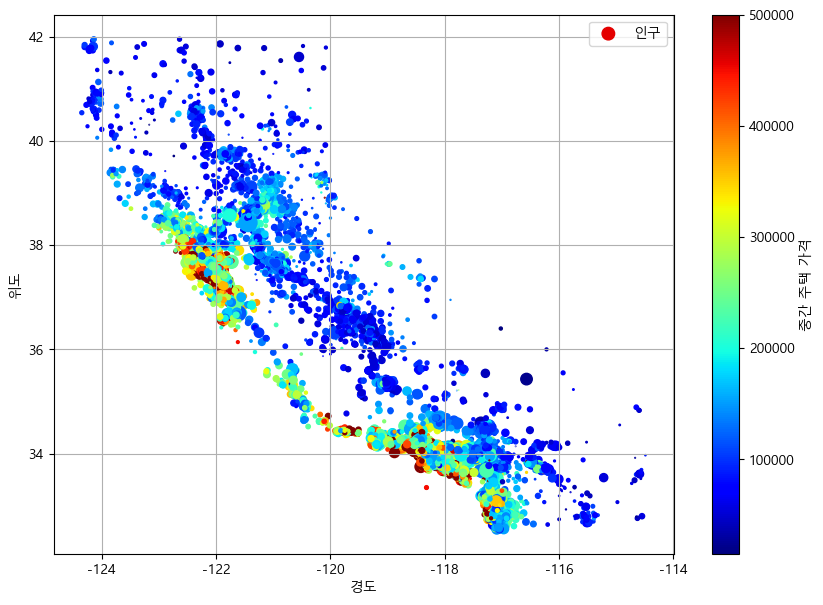

In [178]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, 
             s=housing['population'] / 100, label='인구', 
             c='median_house_value', cmap='jet', colorbar=True,
             legend = True, figsize=(10, 7))
cax=plt.gcf().get_axes()[1]
cax.set_ylabel('중간 주택 가격')
plt.xlabel('경도')
plt.ylabel('위도')
plt.show()

## 상관관계 조사하기

In [179]:
corr_matrix = housing.corr(numeric_only=True)

In [180]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

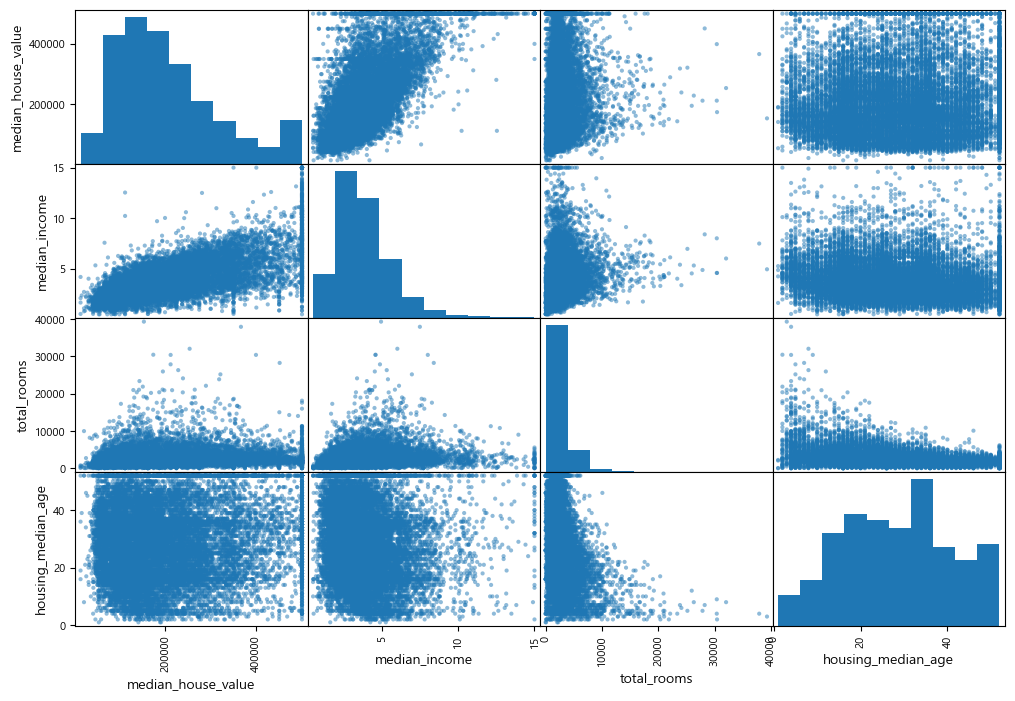

In [181]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

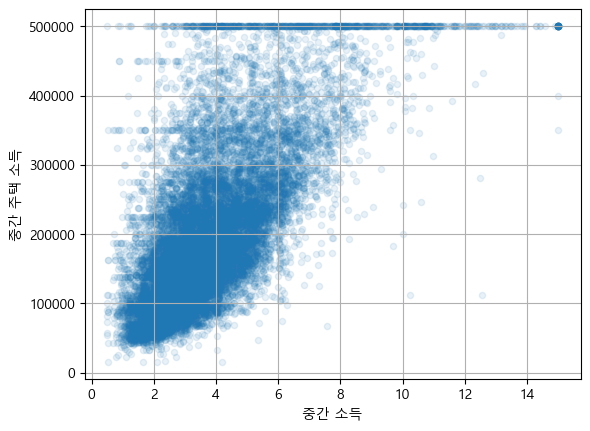

In [182]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', 
             alpha=0.1, grid=True)
plt.xlabel('중간 소득')
plt.ylabel('중간 주택 소득')
plt.show()

## 특성 조합으로 실험하기

In [183]:
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_house'] = housing['population'] / housing['households']

In [184]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.688380
rooms_per_house         0.143663
total_rooms             0.137455
housing_median_age      0.102175
households              0.071426
total_bedrooms          0.054635
population             -0.020153
population_per_house   -0.038224
longitude              -0.050859
latitude               -0.139584
bedrooms_ratio         -0.256397
Name: median_house_value, dtype: float64

# 머신러닝 알고리즘을 위한 데이터 준비

In [185]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

데이터 정제

In [186]:
# 결측치 처리 3가지 방법
# housing.dropna(subset='total_bedrooms', inplace=True) # 행 제거

# housing.drop('total_bedrooms', axis=1, inplace=True) # 열 제거

median = housing['total_bedrooms'].median() # 결측치 대체
housing['total_bedrooms'].fillna(median, inplace=True) 

In [187]:
# 사이킷런을 이용한 결측치 대체
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [188]:
housing_num = housing.select_dtypes(include=[np.number])

In [189]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [190]:
print(imputer.statistics_)
print(housing_num.median().values)

[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]
[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


In [191]:
X = imputer.transform(housing_num)

## 텍스트와 범주형 특성 다루기

In [192]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [193]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [194]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [195]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [196]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [197]:
type(housing_cat_1hot)

scipy.sparse._csr.csr_matrix

In [198]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [199]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [200]:
df_test = pd.DataFrame({"ocean_proximity": ["ISLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [201]:
cat_encoder.transform(df_test)

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [202]:
df_test_unknown = pd.DataFrame({"ocean_proximity":["<2H OCEANn", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEANn,ocean_proximity_ISLAND
0,True,False
1,False,True


In [203]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [204]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [205]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [206]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown).toarray(),
                         columns = cat_encoder.get_feature_names_out(),
                         index = df_test_unknown.index)
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


In [207]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


## 특성 스케일과 변환

In [208]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [209]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [210]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma=0.1)

In [211]:
from sklearn.linear_model import LinearRegression
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())
model = LinearRegression()
model.fit(housing[['median_income']], scaled_labels)
some_new_data = housing[['median_income']].iloc[:5]
scaled_prediction = model.predict(some_new_data)
prediction = target_scaler.inverse_transform(scaled_prediction)

In [212]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[['median_income']], housing_labels)
predictions = model.predict(some_new_data)

## 사용자 정의 변환기

In [213]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[['population']])

In [214]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))

age_simil_35 = rbf_transformer.transform(housing[['housing_median_age']])

In [215]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.01))
sf_simil = sf_transformer.transform(housing[['latitude', 'longitude']])

In [216]:
ratio_transformer = FunctionTransformer(lambda X:X[:,[0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [217]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init___(self, with_mean=True):
        self.with_mean = with_mean
    
    def fit(self, X, y = None):
        X = check_array(X)
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]
        return self
    
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [218]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f'클러스터 {i} 유사도' for i in range(self.n_clusters)]

In [219]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[['latitude', 'longitude']],
                                           sample_weight=housing_labels)

c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [220]:
similarities[:3].round(2)

array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

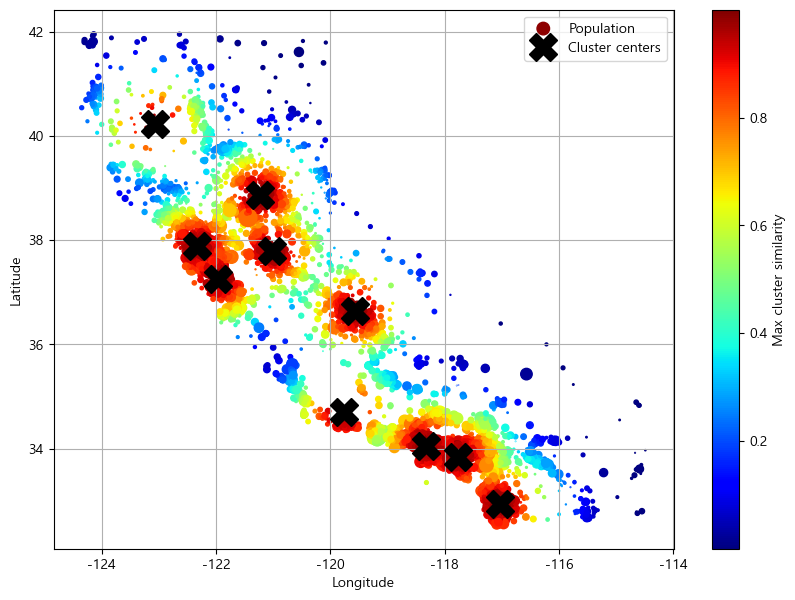

In [221]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed['Max cluster similarity'] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")

plt.legend(loc='upper right')
plt.show()

## 변환 파이프라인

In [232]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])

In [233]:
import sklearn
sklearn.set_config(display='diagram')

In [234]:
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

In [247]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

In [248]:
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [252]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [254]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index
)

In [255]:
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396


In [257]:
num_pipeline.named_steps

{'simpleimputer': SimpleImputer(strategy='median'),
 'standardscaler': StandardScaler()}

In [274]:
from sklearn.compose import ColumnTransformer

num_attribs = housing.select_dtypes(include='number').columns
cat_attribs = housing.select_dtypes(include='object').columns

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [266]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include='object'))
)

In [267]:
housing_prepared = preprocessing.fit_transform(housing)

In [302]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN


In [303]:
# 전체 작업 코드

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ['ratio']

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
,    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler()
)
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

preprocessing = ColumnTransformer([
    ('bedrooms', ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    ('roms_per_house', ratio_pipeline(), ['total_rooms', 'households']),
    ('people_per_house', ratio_pipeline(), ['population', 'households']),
    ('log', log_pipeline, ['total_bedrooms', 'total_rooms', 'population', 'households', 'median_income']),
    ('geo', cluster_simil, ['latitude', 'longitude']),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object)),
],
    remainder = default_num_pipeline
)

In [304]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(16512, 24)

In [305]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'roms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__클러스터 0 유사도', 'geo__클러스터 1 유사도',
       'geo__클러스터 2 유사도', 'geo__클러스터 3 유사도', 'geo__클러스터 4 유사도',
       'geo__클러스터 5 유사도', 'geo__클러스터 6 유사도', 'geo__클러스터 7 유사도',
       'geo__클러스터 8 유사도', 'geo__클러스터 9 유사도',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age'],
      dtype=object)

# 모델 선택과 훈련

## 훈련 세트에서 훈련하고 평가하기

In [306]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D26CCB3950>)])),
                ('linearregression', LinearRegression())])

In [307]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)

array([243700., 372400., 128800.,  94400., 328300.])

In [308]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [311]:
from sklearn.metrics import mean_squared_error
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse

68687.89176590083

In [312]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D26CCB3950>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [314]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse

0.0

## 교차 검증으로 평가하기

In [316]:
from sklearn.model_selection import cross_val_score

tree_rmse = -cross_val_score(tree_reg, housing, housing_labels, scoring='neg_root_mean_squared_error', cv=10)

c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jyj1206\anaconda3\Lib\site-packages\skl

In [317]:
pd.Series(tree_rmse).describe()

count       10.000000
mean     66880.208011
std       2049.481815
min      63649.536493
25%      65429.433745
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

In [324]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmse = -cross_val_score(forest_reg, housing, housing_labels, scoring = 'neg_root_mean_squared_error', cv = 10)

c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jyj1206\anaconda3\Lib\site-packages\skl

In [325]:
pd.Series(forest_rmse).describe()

count       10.000000
mean     47030.511142
std       1029.358881
min      45458.112527
25%      46474.122490
50%      46967.596354
75%      47332.463998
max      49227.030610
dtype: float64

# 모델 미세 튜닝

## 그리드 서치

In [328]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor(random_state=42))
])
param_grid = [
    {'preprocessing__geo__n_clusters':[5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters':[10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jyj1206\anaconda3\Lib\site-packages\skl

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001D26CCB3950>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [330]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [331]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,6.336774,0.016628,0.107846,0.001226,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-43427.121193,-43918.632694,-44754.329230,-44033.361039,547.869959,1
13,8.218319,0.123110,0.126374,0.013460,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-44130.882068,-44075.251239,-45037.459370,-44414.530893,441.062062,2
14,9.763583,0.069313,0.117594,0.011188,15,10,"{'preprocessing__geo__n_clusters': 15, 'random...",-44322.776393,-44285.549219,-45304.543541,-44637.623051,471.828832,3
7,6.327425,0.025738,0.109078,0.001533,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44678.544311,-44654.825561,-45617.268055,-44983.545976,448.213788,4
9,6.767800,0.081545,0.123683,0.004702,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44678.544311,-44654.825561,-45617.268055,-44983.545976,448.213788,4


## 랜덤 서치

In [334]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters' : randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42
)

rnd_search.fit(housing, housing_labels)

c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jyj1206\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jyj1206\anaconda3\Lib\site-packages\skl

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D2071100D0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D20117D090>},
                   random_state=42, scoring='neg_root_mean_squared_error')

앙상블 방법

In [335]:
final_model = rnd_search.best_estimator_
feature_importance = final_model['random_forest'].feature_importances_
feature_importance.round(2)

array([0.07, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.04, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.02, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.  , 0.02, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [336]:
sorted(zip(feature_importance, final_model['preprocessing'].get_feature_names_out()), reverse=True)

[(0.18694559869103852, 'log__median_income'),
 (0.0748194905715524, 'cat__ocean_proximity_INLAND'),
 (0.06926417748515577, 'bedrooms__ratio'),
 (0.05446998753775219, 'roms_per_house__ratio'),
 (0.05262301809680712, 'people_per_house__ratio'),
 (0.03819415873915732, 'geo__클러스터 0 유사도'),
 (0.02879263999929514, 'geo__클러스터 28 유사도'),
 (0.023530192521380396, 'geo__클러스터 24 유사도'),
 (0.020544786346378206, 'geo__클러스터 27 유사도'),
 (0.019873052631077512, 'geo__클러스터 43 유사도'),
 (0.018597511022930273, 'geo__클러스터 34 유사도'),
 (0.017409085415656868, 'geo__클러스터 37 유사도'),
 (0.015546519677632162, 'geo__클러스터 20 유사도'),
 (0.014230331127504292, 'geo__클러스터 17 유사도'),
 (0.0141032216204026, 'geo__클러스터 39 유사도'),
 (0.014065768027447325, 'geo__클러스터 9 유사도'),
 (0.01354220782825315, 'geo__클러스터 4 유사도'),
 (0.01348963625822907, 'geo__클러스터 3 유사도'),
 (0.01338319626383868, 'geo__클러스터 38 유사도'),
 (0.012240533790212824, 'geo__클러스터 31 유사도'),
 (0.012089046542256785, 'geo__클러스터 7 유사도'),
 (0.01152326329703204, 'geo__클러스터 23 유사도'),
 (0.0

In [338]:
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)

In [341]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc = squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39275.40861216, 43467.27680583])

론칭, 모니터링, 시스템 유지 보수

In [342]:
import joblib

joblib.dump(final_model, 'my_califonia_housing_model.pkl')

['my_califonia_housing_model.pkl']

In [343]:
import joblib

final_model_reloaded = joblib.load('my_califonia_housing_model.pkl')

In [344]:
final_model_reloaded

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000001D...
                                                  ClusterSimilarity(n_clusters=45,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D25E5B9B10>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=9, random_state=42))])